# 🐶 End to End - Multiclass Dog Breed Classifications

This notebook builds an End-to-End Multiclass Dog Breed Classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1.Problem
Identifying the breed of a dog given an image of a dog.


## 2.Data
[Dog Breed Identification - Kaggle Version](https://www.kaggle.com/c/dog-breed-identification/data)

## 3.Evaluation

- evaluated on `Multi Class Log Loss` between the predicted probability and the observed target.
- The evaluation is the file with prediction probabilities for each dog breed of each test image.

## 4.Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dog (120 different classes).
* There are about 10,000+ images in both Training and Test Set.



# Setting up Data



In [1]:
# unzip the file
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

-----------

# Get our Workspace Ready

In [2]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

# check for GPU availbility
print("GPU", 'available' if tf.config.list_physical_devices('GPU') else 'Not available.')

TF version:  2.4.1
Hub version:  0.11.0
GPU available


--------

# Getting our Data Ready (turning into Tensors)

- With all machine learning model, our data needs to be in numerical format. Turning our images into Tensors (numerical representations).

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## let's access our data and check out the labels.
Unlike structured data, **unstructured data (images) have 2 parts for training data**.
* data labels
* data images themselves

In [5]:
labels_csv = pd.read_csv('drive/My Drive/Dog Vision/labels.csv')

print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     5575b889e08a47aefa3e787931c6cc19  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## How many images are for each breed?

In [7]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

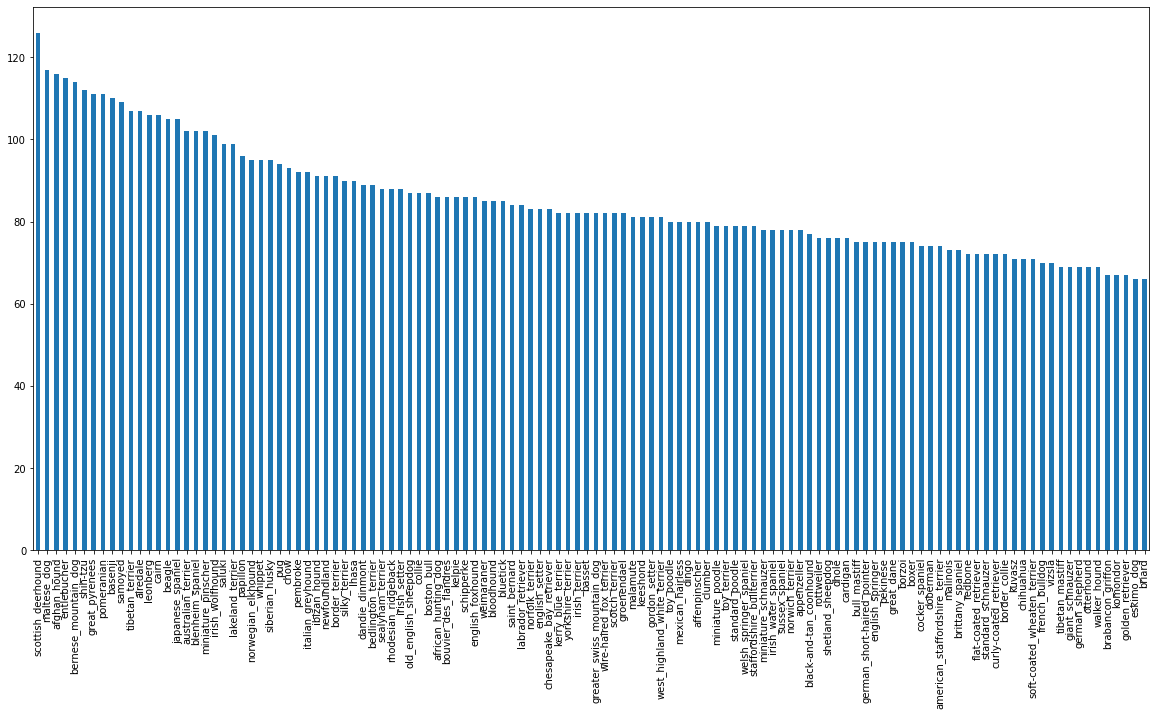

In [8]:
# visualize the data
plt.figure(figsize=(20,10))
labels_csv['breed'].value_counts().plot(kind='bar');

In [9]:
# what is the median of number of dogs per breed
labels_csv['breed'].value_counts().median()

82.0

There are abou 82 dogs per dog breed.

As per google recommendation, mininum images per class should be at least 10.

https://cloud.google.com/vision/automl/object-detection/docs/prepare

* `For each label you must have at least 10 images, each with at least one annotation`

* `However, for model training purposes it's recommended you use about 1000 annotations per label. In general, the more images per label you have the better your model will perform.`


In [10]:
# let's explor an image
from IPython.display import Image

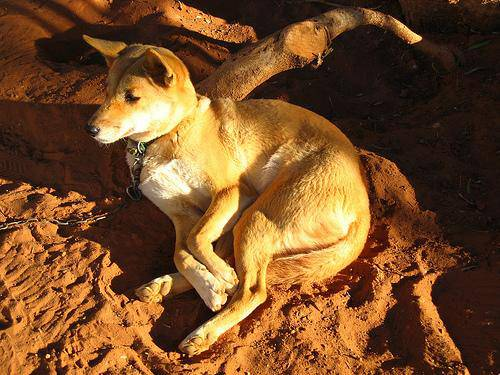

In [11]:
Image(data='/content/drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

-----------

## Getting Images and their labels

let's get the list of all of our images file pathnames.

In [12]:
labels_csv.head(2)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo


In [13]:
# create pathnames from image IDs
folder_path = '/content/drive/MyDrive/Dog Vision/train/'
file_extension = '.jpg'

filenames = [folder_path+fname+file_extension for fname in labels_csv['id']]

# check first 5 rows
filenames[:5]

['/content/drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [14]:
 # check whether number of file name matched actual image file names
import os
if  len(os.listdir('/content/drive/MyDrive/Dog Vision/train/')) == len(filenames):
  print('filenames folder has the same number of images as in train folder. You can proceed !!!')
else:
  print('filenames folder doe not have the same number of images as in train folder.')


filenames folder has the same number of images as in train folder. You can proceed !!!


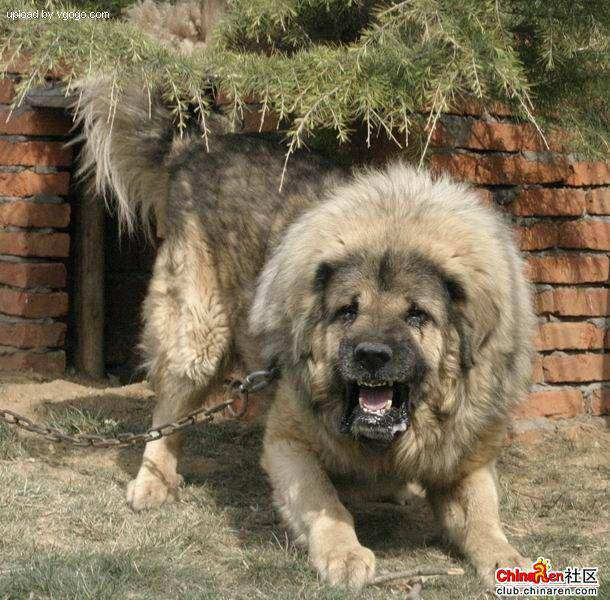

In [15]:
# random check
Image(filenames[9000])

In [16]:
labels_csv['breed'][9000]

'tibetan_mastiff'

-----------

-------------

# Truning Data Labels into Numbers

Since we've got our training image filepaths in a list, let's prepare our labels.

In [17]:
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
len(labels)

10222

## See if the number of labels match the number of filenames
- checking lables against images in train folder

In [19]:
if len(labels) == len(filenames):
  print('Number of labels matches number of filenames')
else:
  print('Number of labels do not match number of filenames. Check data directories!')

Number of labels matches number of filenames


## Find the unique label value counts

In [20]:
# find the unique label value counts
unique_breeds = np.unique(labels)

unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [21]:
len(unique_breeds)

120

In [22]:
# Example: turn single label into an arrary of booelans 
print(labels[0])

labels[0] == unique_breeds

# we can see that for location where the value is boston_bull, it returns True.

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

## Turn every data labels into a boolean array

In [23]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

# we can see that for 120 unique breed labels, every breed has it own boolean arary with Flag is True  where the value for that breed appears.

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [24]:
len(boolean_labels)

10222

## Turning boolean array into Integers

In [25]:
# Example: turning boolean array into integers

print(labels[0]) # original label
print(np.where(labels[0] == unique_breeds)) # index where this specific label occurs in unique_breeds array
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be 1 where the sample label occurs 

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [26]:
print(labels[2]) # original label
print(np.where(labels[2] == unique_breeds)) # index where this specific label occurs in unique_breeds array
print(boolean_labels[2].argmax()) # index where label occurs in boolean array
print(boolean_labels[2].astype(int)) # there will be 1 where the sample label occurs 

pekinese
(array([85]),)
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


-------


## Creating our own validation set
 Since the dataset form Kaggle doesn't come with validation set, we are going to create our own one.

### Set up X & y variables


In [27]:
X = filenames
y = boolean_labels

As our dataset is quite large (10,222), we want to start expirement with a little chuck first (1,000 images) and increase as needed.

### Set number of images to use for experimenting

In [28]:
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10222, step:1000}

### Split Data into Train and Validation sets

In [29]:
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], 
                                                                        y[:NUM_IMAGES], 
                                                                        test_size=0.2, 
                                                                        random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [31]:
# let's check quick on those train and test data

X_train[:2], y_train[:2]

(['/content/drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,

----------

# Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors, we're going to write a function which does the following things:

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to variable, `image`
3. Turn our `image` (jpg file) into Tensors
4. Normalize our image (convert color channels from 0-255) to 0-1
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

[Load data - image Documentation](https://www.tensorflow.org/tutorials/load_data/images)

[Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

### Example: Convert an image into Numpy array

In [32]:
from matplotlib.image import imread

image = imread(filenames[42])  # just get a random image which is located in index 42
image.shape

(257, 350, 3)

We can see that when we converted image into numpy array, it is 3D array. 
* height
* width
* color channel (RGB) with ranges from 0 to 255 value

In [33]:
image.max()

255

In [34]:
image.min()

0

In [35]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

### Convert Numpy arrary into Tensors
* Tensors are very much similar to Numpy array. We can see in below that now image is converted into Tensor object with additional parameters avaliable.

* Tensors are able to run on GPU, making them a lot faster to process to find patterns in them.

* we can simply convert to Tensor object by using `tf.constant()`


In [36]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

## Preprocessing Image Function

Now we have seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to variable, `image`
3. Turn our `image` (jpg file) into Tensors
4. Normalize our image (convert color channels from 0-255) to 0-1
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [37]:
# define desired image size
IMG_SIZE = 224

# create function for preprocessing image
def process_image(img_path, img_size=IMG_SIZE):
  """
  Takes an image form image path with desired Image size,  and turns the image into a Tensor.
  """
  # Read an image file
  image = tf.io.read_file(img_path)

  # Turn jpeg image into numerical tensor with RGB channel
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channels from 0-255 to 0-1 value (Normalize)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Reize the image to our desired size (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  # return the modified object
  return image

# Turning Data into Batches

Why turn our data into batches?

- let's say you are processing 10,000+images in one go, they all might not fit into memory. That's why we want to process by batch.
- we can adjust batch size if needed.
- **Best Batch Size: 32 images**
- In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this: **(image tensor, label)**. This means we are tagging a label (what our model thinks about this specific type of image) and the image itself together.



### Create a simple function to return a tuple (image, label)

In [38]:
# create a simple function to return a tuple (image, label)
def get_image_label(img_path, label):
  """
  Takes an image file path name and associated label. 
  Preprocess the image and returns  a tuple of (image, label).
  """
  image = process_image(img_path)
  return image, label

In [39]:
# demo of above function line
# we can see that both image and label are in tensor objects.
(process_image(filenames[42]), tf.constant(labels[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

### Looping through X, y turning into Tensors in Batches

Now we've got a way to turn our data into tuples of Tensors in the form : `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches.

[why we use batch size of 32](https://twitter.com/ylecun/status/989610208497360896?s=20)

In [40]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffle the data if it is training data, but doesn't shuffle if it is validation data.
  Also accepts test data as input (no labels).
  """
  # if it is a test set, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # if it is validation set, we don't need to shuffle it.
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                                      tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  # if it is training set, we want to shuffle it.
  else:
    print('Creating training data batches...')

    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                                      tf.constant(y)))
    
    # Shuffling pathnames and labels
    # we will do shufffling before image processing, because it is faster to do it first than doing it after image processing
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn training dataset into batches
    data_batch = data.batch(batch_size)
    return data_batch
    

### Create Training and Validation Set Databatches

In [41]:
# create Training and Validation Set Databatches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


### Check out the different attributes of our data batches

In [42]:
train_data.element_spec, val_data.element_spec

# it is in (image, label) tuple pair of Tensor objects
# For X, 
    # shape=(defined-batch-size, height, width, colorchannel)
# For y, 
    # shape=(defined-batch-size, height)

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

----------

# Visualizing Data Batches

We have turned our data into batches, however it can be a little hard to understand/comprehend. We may want to visualize our data to make a full sense of how it looks like.

In [43]:
import matplotlib.pyplot as plt

In [44]:
# create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels from a data batch
  """
  # set up figure
  plt.figure(figsize=(10, 10))

  # loop through 25 images
  for i in range(25):
    # create a subplot (5 rows, 5 cols)
    ax = plt.subplot(5, 5, i+1) # row, cols, indexes
    # display an image
    plt.imshow(images[i])
    # add image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid line off
    plt.axis('off')


In [45]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [46]:
# as our data in batches, we need to unbatch it first
# we will get the first batch by using iterator of next()
train_images, train_labels = next(train_data.as_numpy_iterator()) 

train_images, train_labels

(array([[[[0.9960919 , 0.9882488 , 0.99693763],
          [1.        , 0.99312854, 1.        ],
          [0.99928886, 0.993548  , 0.9913481 ],
          ...,
          [0.61337054, 0.64089954, 0.70341045],
          [0.6422653 , 0.6697163 , 0.70579815],
          [0.7412492 , 0.76870024, 0.7981295 ]],
 
         [[0.9897659 , 0.98775256, 0.95961004],
          [1.        , 0.99899334, 0.9791532 ],
          [1.        , 0.9999191 , 0.9664283 ],
          ...,
          [0.65650624, 0.6811232 , 0.73732734],
          [0.6438922 , 0.67470056, 0.6894231 ],
          [0.77195865, 0.80523944, 0.80836445]],
 
         [[0.989867  , 0.993437  , 0.91627634],
          [0.96557254, 0.9705729 , 0.8990022 ],
          [0.98874664, 0.9936048 , 0.9246097 ],
          ...,
          [0.7417697 , 0.75731415, 0.7983383 ],
          [0.6101093 , 0.6455456 , 0.63722754],
          [0.6864345 , 0.7220883 , 0.7050794 ]],
 
         ...,
 
         [[0.70101124, 0.68568456, 0.64234465],
          [0.65619

In [47]:
# we can see that first batch which consists of 32 images have been returned.
len(train_images), len(train_labels)

(32, 32)

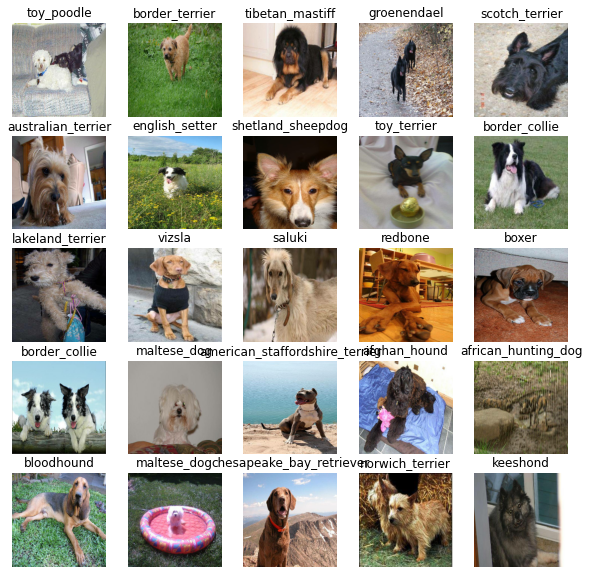

In [48]:
# now let's visualize data
show_25_images(train_images, train_labels)

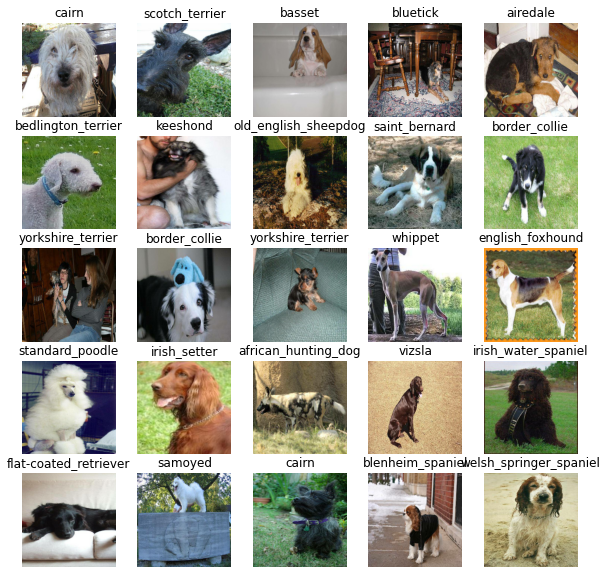

In [49]:
# now let's visualize the validation set
val_images, val_labels = next(val_data.as_numpy_iterator())

# show 25 images
show_25_images(val_images, val_labels)


--------


# Building a Model

Before we build a model, there are a few things we need to define.
1. Input shape (our images shape, in the form of Tensors) to our model.
2. Output shape (images labels, in the form of  Tensors) of our model.
3. The URL of the model we want to use from Tensorflow hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [50]:
# 1. Set up Input Shape to our model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  # batch size, height, width, color channel

# 2. Set up Output Shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# 3. Set up model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

## Putting together as Keras Deep Learning Model

Now we've got our input, output and URL ready to go.
Let's put them together into Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape, chosen model as parameters
* Defines layers in keras model in sequential fashion (do this first, do that later)
* Compiles the model (says how it should be evaluated and imporved).
* Builds the model (tell the model - the input shape it will be getting).
* Returns the model.

All of these steps can be found [here](https://www.tensorflow.org/guide/keras/sequential_model)


--------

- softmax: after applying softmax, each component will be in the interval (0,1), and the components will add up to 1

In [51]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url = MODEL_URL):
  print('Building model with {}'.format(model_url))
  # Defines layers in sequential fashion
  model = tf.keras.Sequential([
                    hub.KerasLayer(model_url), # layer 1 (input layer)
                    tf.keras.layers.Dense(units=output_shape, 
                                                      activation='softmax')  # layer 2 (outpt layer)
  ])

  # Compiles the model (define how the model is going to learn)
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )

  # Build the model
  model.build(input_shape)

  # Return the model
  return model

In [78]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [74]:
test = np.ones(shape=(2,3,5))  # layers (how many sets of those rows and columns), rows, columns
test

array([[[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]])

In [73]:
test = np.ones(shape=(4,2,3,5))
test

array([[[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]],


       [[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]]])

# Creating a Callback

Callbacks are helper function, a model can use during training to do such things as:
-  Save its progress, 
- Check its progress, 
- Stop training early if a  model stops improving, etc.

We will create two callbacks.
- one for for TensorBoard which helps track our models progress
- another for early stopping which prevents our model from training too long.


## TensorBoard Callback

To set up a TensorBoard Callback,
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model `fit` function
3. Visualize our models training logs with the `%tensorboard` magic function (we will do this after model training).

In [79]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [80]:
import datetime

# Create Tensorboard Callback
log_folder_path = folder_path + '/logs'

def create_tensorboard_callback():
  # create a log directory for storing tensorboard callbacks
  logdir = os.path.join(log_folder_path,
                                  datetime.datetime.now().strftime('%Y%m%d-%H%M%S')) # make the log folder to get tracked whenever we run the expirement
  return tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Early Stopping Callback

- prevents model from overfitting. 
- When the model runs too long  for training, it can overfit to that dataset which might lead it doing poorly to new datasets (meaning it doesn't generalize well).
- it stops the model from continue running, when the **certain evaluation metrics STOPS improving**.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [82]:
# Create Early Stopping Callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                              patience=3)

-----------

# Training Deep Neural Network


### Training model (on subset of data)

Our first model is only going to train on 1,000 images to make sure everything is working.